In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
metrix.describe()

,index,vote,category
count,110399.000000,110399.000000,110399.000000
mean,55293.672760,0.802462,0.658339
std,31934.267313,5.325085,1.348985
min,0.000000,0.000000,0.000000
25%,27636.500000,0.000000,0.000000
50%,55286.000000,0.000000,0.000000
75%,82947.500000,0.000000,1.000000
max,110629.000000,341.000000,8.000000


# 데이터 불러오기

In [4]:
senegi = pd.read_csv('zolzak.csv', index_col = 0)
free = pd.read_csv('everytime_data.csv', index_col = 0)

free.columns = ["time", "comment","comment_number","vote"]

# 데이터 확인

In [521]:
senegi.head()

,time,comment,vote,comment_number
0,6분 전,"파일 두개 같이 못올리는거 같은데 고친 내용은 직접 작성란에 작성하는건가,,?? 아...",0,0
1,18분 전,아잉 수업시간에 들었던 자료 다시 들어볼수있나요???,0,0
2,09/10 20:49,아잉 자기소개 영상 찍어서 올리는거 다들 하셨나요? 영상찍어서 올렸는데 업로드가 안...,0,2
3,09/10 20:44,낼 아침에 마감인데 아잉 자기소개 영상 아직도 안 찍음 하아 너무 하기 싫어,0,3
4,09/10 17:33,교수님 말 왤캐 더듬어....더듬어서 먼 말인지 모르겠음 ㅋㅋ,0,9


# 데이터 전처리

In [5]:
#free['comment'] = free['comment'].str.replace('?', '물었다')
#senegi['comment'] = senegi['comment'].str.replace('?', '물었다')

def text_cleaning(text):
    hangul = re.compile('[^가-힣?]')
    result = hangul.sub(' ',text)
    return result

senegi['comment'] = senegi['comment'].apply(lambda x : text_cleaning(x))
free['comment'] = free['comment'].apply(lambda x : text_cleaning(x))

senegi['time'].loc[0] = '09/10 21:13'
senegi['time'].loc[1] = '09/10 21:07'

senegi['time'].iloc[10624:] = senegi['time'].apply(lambda x: f"20{x}")
senegi['time'].iloc[:10624] = senegi['time'].apply(lambda x: f"2020/{x}")
senegi['time'] = pd.to_datetime(senegi['time'])

senegi = senegi[["time", "comment","comment_number","vote"]]
free = free[["time", "comment","comment_number","vote"]]

metrix = pd.concat([free[['comment','vote']], senegi[['comment','vote']]], axis = 0, ignore_index=True)

metrix= pd.DataFrame(metrix).copy()
metrix
metrix.drop_duplicates(inplace = True)
metrix.reset_index(inplace = True)

C:\Users\82109\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [25]:
senegi.shape

(16820, 5)

In [27]:
metrix.shape

(110399, 3)

# 데이터시각화

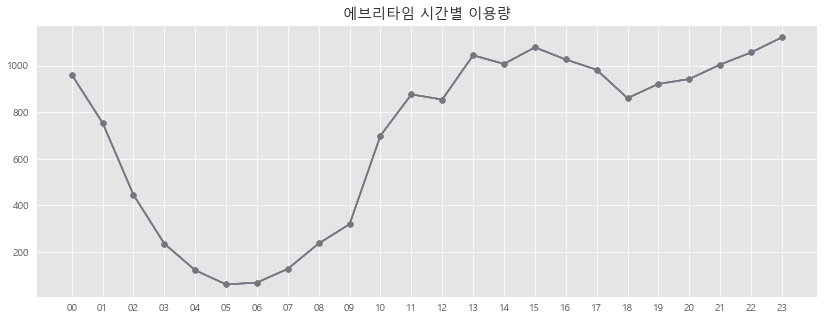

In [24]:
senegi['time_index'] = senegi.index.strftime('%H')
graph = senegi.groupby(senegi['time_index']).count()
plt.figure(figsize = (14,5))
plt.plot(graph, marker = 'o', markersize=5)
plt.title('에브리타임 시간별 이용량')
plt.show()

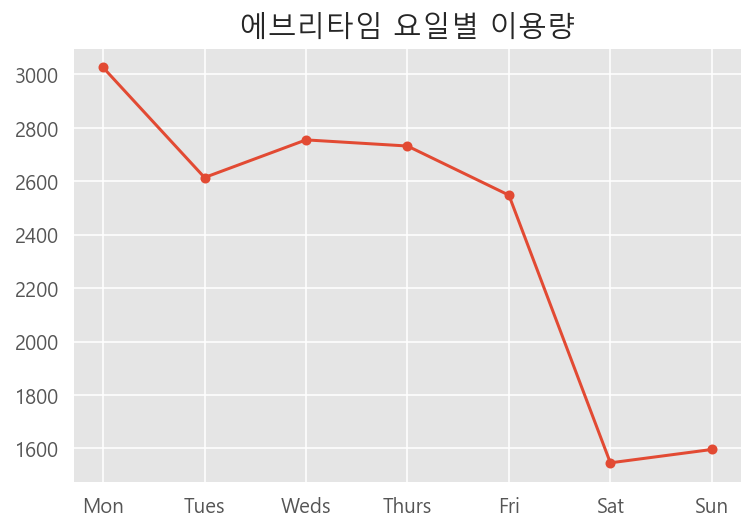

In [251]:
import datetime

senegi['day_of_week']=senegi.index.weekday
days = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
senegi['day_of_week'] = senegi['day_of_week'].apply(lambda x: days[x])

plots = senegi['day_of_week'].value_counts()

plots = plots.reindex(index=['Mon', 'Tues', 'Weds', 'Thurs', 'Fri', 'Sat', 'Sun'])

plt.plot(plots, marker='o', markersize=4)
plt.title('에브리타임 요일별 이용량')
plt.show()

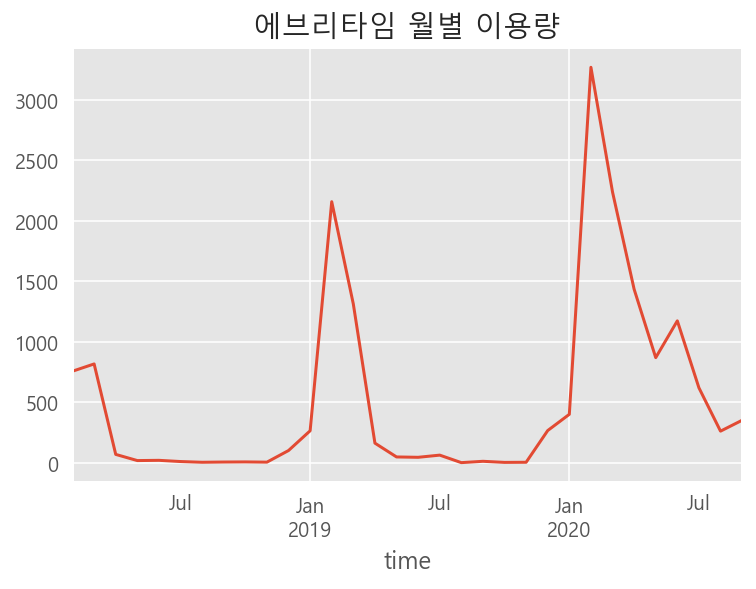

In [250]:
senegi.drop(senegi.index[10624], inplace=True)
senegi['time'].resample('M').count().plot(title = '에브리타임 월별 이용량')

In [227]:
from konlpy.tag import Okt
from collections import Counter

hakgi_0911 = pd.concat([senegi['2018-09':'2018-11'], senegi['2019-09':'2019-11'], senegi['2020-09']])
hakgi_0306 = pd.concat([senegi['2018-03' : '2018-06'], senegi['2019-03' : '2019-06'], senegi['2020-03' : '2020-06']])
hakgi_1202 = pd.concat([senegi['2018-02'], senegi['2018-12' : '2019-02'], senegi['2019-12' : '2020-02']])
hakgi_0708 = pd.concat([senegi['2018-07' : '2018-08'], senegi['2019-07' : '2019-08'], senegi['2020-07' : '2020-08']])


def get_nouns(x):
    stopworded = ['가요','주차','사람','신청','오늘']
    okt = Okt()
    c = "".join(x['comment'].tolist())
    nouns = okt.nouns(c)
    nouns = [noun for noun in nouns if len(noun) > 1]
    nouns = [noun for noun in nouns if noun not in stopworded]
    last = Counter(nouns)
    return last.most_common(n=10)

hakgi_0911 = get_nouns(hakgi_0911)
hakgi_0311 = get_nouns(hakgi_0306)
hakgi_1202 = get_nouns(hakgi_1202)
hakgi_0708 = get_nouns(hakgi_0708)

def listed(x):
    word = []
    number = []
    for i in range(len(x)):
        word.append(x[i][0])
        number.append(x[i][1])
    df = pd.DataFrame({'word' : word, 'number' : number})
    return df

a = listed(hakgi_0311)
b = listed(hakgi_0911)
c = listed(hakgi_0708)
d = listed(hakgi_1202)


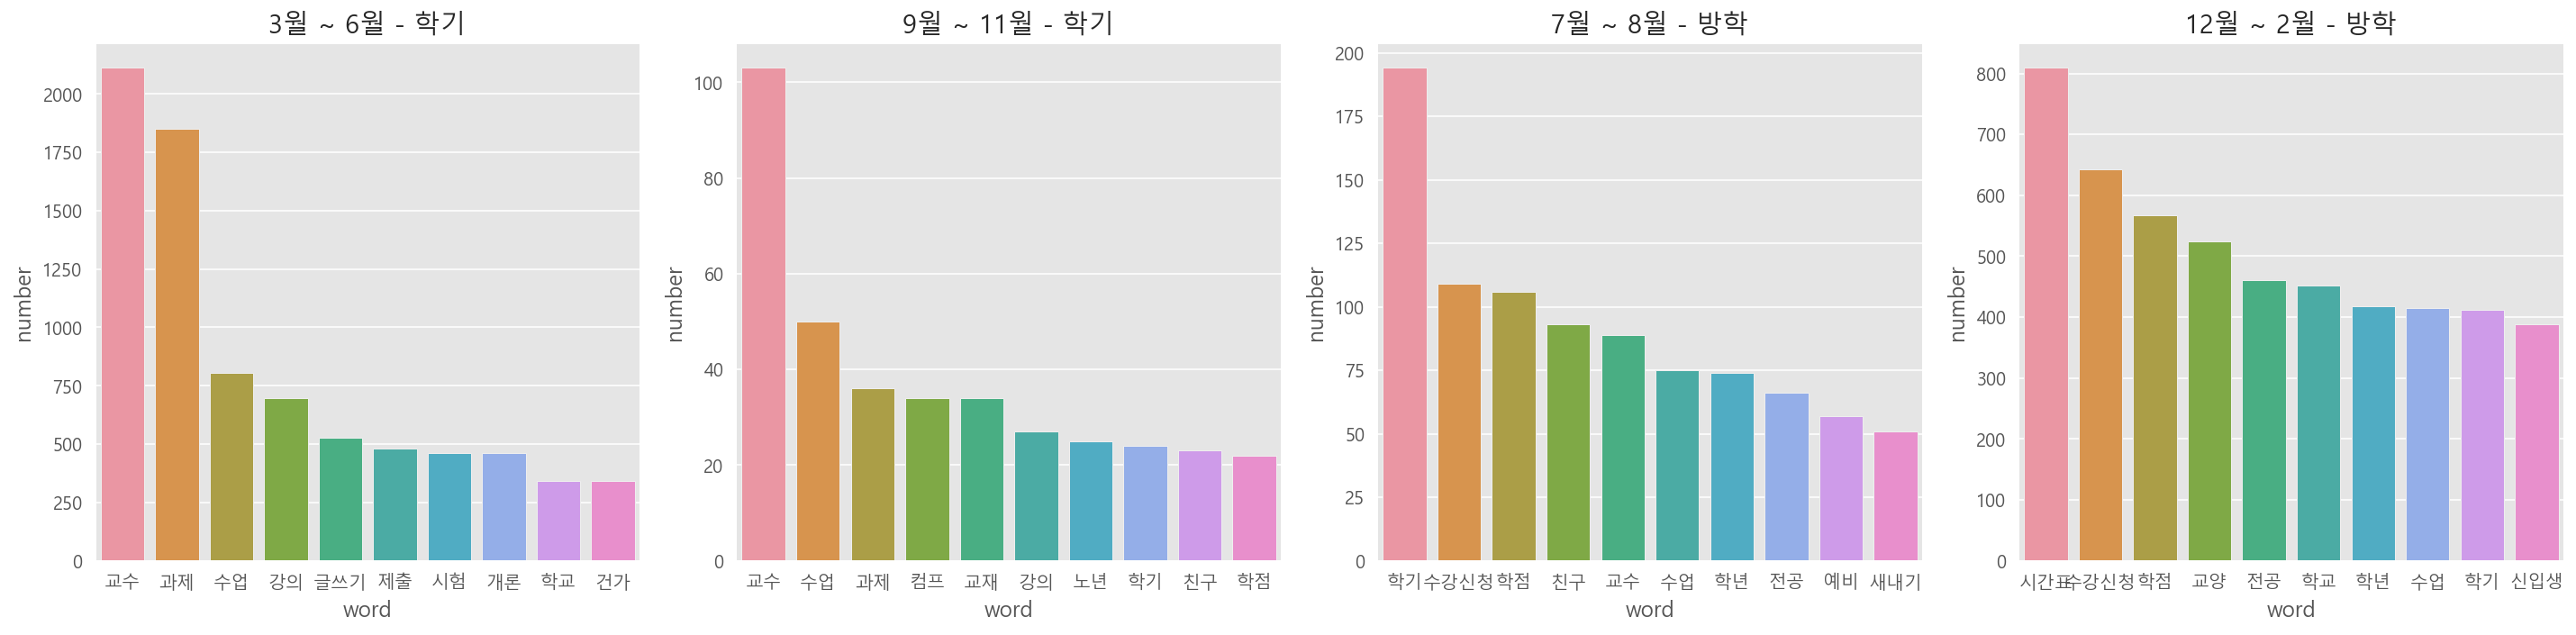

In [228]:
plt.rcParams['font.family'] = 'Malgun Gothic'
fig, ax = plt.subplots(1,4, figsize = (20,5))

sns.barplot('word', 'number', data = a, ax = ax[0])
sns.barplot('word', 'number', data = b, ax = ax[1])
sns.barplot('word', 'number', data = c, ax = ax[2])
sns.barplot('word', 'number', data = d, ax = ax[3])
ax[0].set_title('3월 ~ 6월 - 학기')
ax[1].set_title('9월 ~ 11월 - 학기')
ax[2].set_title('7월 ~ 8월 - 방학')
ax[3].set_title('12월 ~ 2월 - 방학')
plt.tight_layout()


글의 최대 길이 :  348
글의 평균 길이 :  45.76623376623377


Text(0, 0.5, 'number of Data')

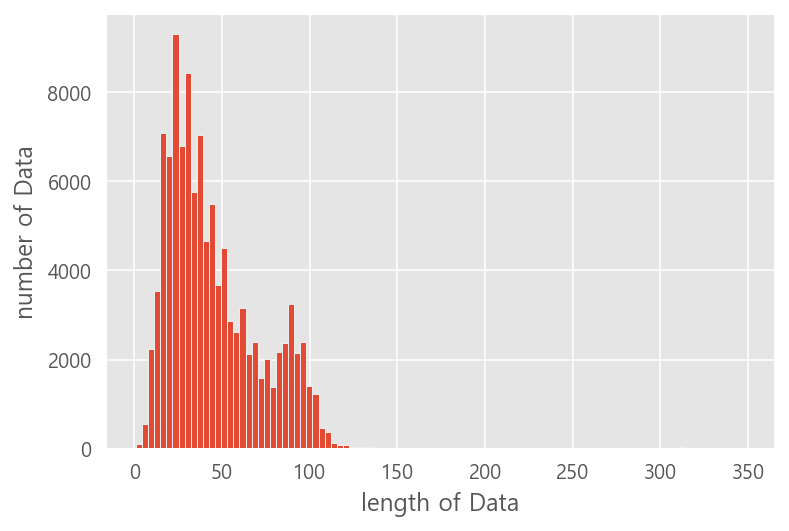

In [245]:
print("글의 최대 길이 : ", max(len(i) for i in metrix['comment']))
print("글의 평균 길이 : ", sum(map(len, metrix['comment']))/ len(metrix['comment']))

plt.hist([len(s) for s in metrix['comment']], bins = 100)
plt.xlabel('length of Data')
plt.ylabel('number of Data')

Text(0, 0.5, '')

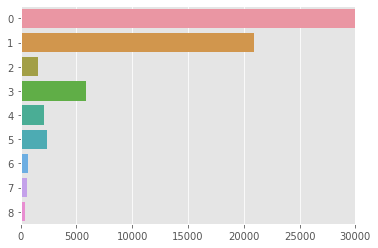

In [7]:
plt.style.use('ggplot')
sns.countplot(y = 'category', data = metrix)
plt.xlim(-1,30000)
plt.xlabel('')
plt.ylabel('')

In [13]:
from konlpy.tag import Okt
from collections import Counter
def get_nouns(x):
    okt = Okt()
    c = "".join(x.tolist())
    nouns = okt.nouns(c)
    nouns = [noun for noun in nouns if len(noun) > 1]
    nouns = [noun for noun in nouns if noun not in datascience_list]
    return Counter(nouns)


a8 = get_nouns(metrix[metrix['category'] == 7]['comment'])



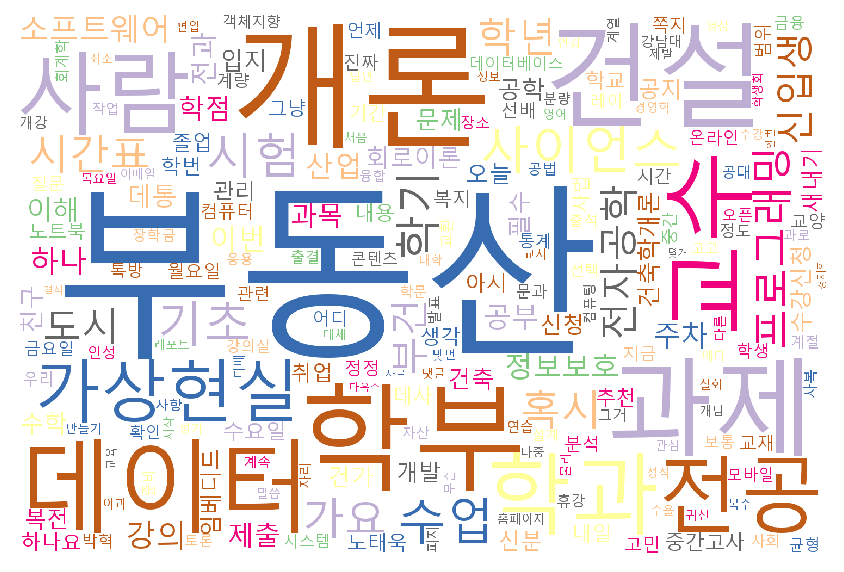

In [14]:
from wordcloud import WordCloud 

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
%matplotlib inline

import matplotlib
from IPython.display import set_matplotlib_formats
matplotlib.rc('font',family = 'Malgun Gothic')

set_matplotlib_formats('retina')

matplotlib.rc('axes',unicode_minus = False)



wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', background_color='white'
                        ,colormap = "Accent_r", width=1500, height=1000).generate_from_frequencies(a8)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud) 
plt.axis('off')
plt.show()



# 사전 불러오기

In [315]:
"""import codecs

word_list = ['stopwords', 'hengzung', 'gyoyang', 'gyoyang_pilsu',
             'bokzi', 'gyoungyoung', 'global', 'datascience', 'edu', 'campus']


def word_label(word):
    word_path = word[i] + ".txt"
    with open(word_path) as f:
        word[i] = f.readlines()
    word[i] = [x.strip() for x in word[i]]

korean_stopword_path = 'stopwords.txt'
with open(korean_stopword_path, encoding='UTF-8') as f:
    stopword = f.readlines()
stopwords_list = [x.strip() for x in stopword]

kangnam_hengzung_path = 'hengzung.txt'
with open(kangnam_hengzung_path, encoding='UTF-8') as f:
    hengzung_list = f.readlines()
hengzung_list = [x.strip() for x in hengzung_list]

hengzung_list = []
hengzung = codecs.open("hengzung.txt", 'rb', encoding='UTF-8')
while True:
    line = hengzung.readline() 
    line = line.replace('\n', '')
    line = line.replace('\r', '')
    hengzung_list.append(line) 
    if not line:
        break 
hengzung.close()

gyoyang_list = []
gyoyang = codecs.open("gyoyang.txt", 'rb', encoding='UTF-8')
while True:
    line = gyoyang.readline() 
    line = line.replace('\n', '')
    line = line.replace('\r', '')
    gyoyang_list.append(line) 
    if not line:
        break 
gyoyang.close()

gyoyang_pilsu_list = []
gyoyang_pilsu = codecs.open("gyoyang_pilsu.txt", 'rb', encoding='UTF-8')
while True:
    line = gyoyang_pilsu.readline() 
    line = line.replace('\n', '')
    line = line.replace('\r', '')
    gyoyang_pilsu_list.append(line) 
    if not line:
        break 
gyoyang_pilsu.close()


bokzi_list = []
bokzi = codecs.open("bokzi.txt", 'rb', encoding='UTF-8')
while True:
    line = bokzi.readline() 
    line = line.replace('\n', '')
    line = line.replace('\r', '')
    bokzi_list.append(line) 
    if not line:
        break 
bokzi.close()

gyoungyoung_list = []
gyoungyoung = codecs.open("gyoungyoung.txt", 'rb', encoding='UTF-8')
while True:
    line = gyoungyoung.readline() 
    line = line.replace('\n', '')
    line = line.replace('\r', '')
    gyoungyoung_list.append(line) 
    if not line:
        break 
gyoungyoung.close()

global_list = []
gloBal = codecs.open("global.txt", 'rb', encoding='UTF-8')
while True:
    line = gloBal.readline() 
    line = line.replace('\n', '')
    line = line.replace('\r', '')
    global_list.append(line) 
    if not line:
        break 
gloBal.close()

datascience_list = []
datascience = codecs.open("datascience.txt", 'rb', encoding='UTF-8')
while True:
    line = datascience.readline() 
    line = line.replace('\n', '')
    line = line.replace('\r', '')
    datascience_list.append(line) 
    if not line:
        break 
datascience.close()

edu_list = []
edu = codecs.open("edu.txt", 'rb', encoding='UTF-8')
while True:
    line = edu.readline() 
    line = line.replace('\n', '')
    line = line.replace('\r', '')
    edu_list.append(line) 
    if not line:
        break 
edu.close()

campus_list = []
campus = codecs.open("campus.txt", 'rb', encoding='UTF-8')
while True:
    line = campus.readline() 
    line = line.replace('\n', '')
    line = line.replace('\r', '')
    campus_list.append(line) 
    if not line:
        break 
campus.close()


In [10]:
word_list = ['hengzung', 'gyoyang', 'gyoyang_pilsu',
             'bokzi', 'gyoungyoung', 'global', 'datascience', 'edu']

hengzung_list = []
gyoyang_list = []
gyoyang_pilsu_list = []
bokzi_list = []
gyoungyoung_list = []
global_list = []
datascience_list = []
edu_list = []

text_list = [hengzung_list, gyoyang_list, gyoyang_pilsu_list, gyoungyoung_list,
            bokzi_list, global_list, datascience_list,
             edu_list]

def word_label(word):
    word_path = word + ".txt"
    with open(word_path, encoding='UTF-8') as f:
        word = f.readlines()
    word = [x.strip() for x in word]
    return word

for i in range(len(word_list)):
    text_list[i] = word_label(word_list[i])
stopwords_list = word_label('stopwords')

# 데이터 라벨링

0 - 기타, 1 - 행정, 2 - 교양, 3 - 교양필수, 4 - 경영, 5 - 복지, 6 - 글로벌, 7 - ict, 8 - 사범, 9 - 캠퍼스관련



In [10]:
metrix['category'] = 0

def labeling(df, text, label_number):
    
    false_true = True
    text_sum = 0
    
    for i in range(len(df)):
        
        false_true = True

        for z in text:
            if (df['comment'][i].find(z) >= 0) == True and (df['vote'][i] < 2) == True and len(df['comment'][i]) <= 140:
                text_sum += 2
                
                if (df['comment'][i].find('?') >= 0) == True:
                    if false_true == True:
                        text_sum += 1
                        false_true = False
                        
                if text_sum >= 3:
                    df['category'][i] = 1
        text_sum = 0
                
    return df

number=0
while number <= 7:
    metrix = labeling(metrix, text_list[number], number+1)
    print(number)
    number += 1
    

C:\Users\82109\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0
1
2
3
4
5
6
7


In [85]:
metrix.to_csv('end_game.csv')

In [11]:
metrix['category'].value_counts()

0    76079
1    34320
Name: category, dtype: int64

# 테스트 세트 불러오고 전처리

In [3]:
test = pd.read_csv('zolzak_test.csv', index_col = 0)
metrix = pd.read_csv('end_game.csv', index_col = 0)
test['comment'] = test['comment'].apply(lambda x : text_cleaning(x))
test_set = pd.DataFrame({'comment' : test['comment']})
test_set.head()

,comment
0,글쓰기 이번학기첨인데 자료수집부터 막막쓰
1,컴프 과제 책을 얼마나 사야하냐 ㅆㅂ 진짜
2,그 강의 배속해서 듣는거 있자나 그걸로 빨리들어서 분만에 강의 다 듣고 출석에 ...
3,사회문제론 금요일꺼 수강하고 있는데 왜 자꾸 강의랑 과제는 수요일에 올리고 기한도 ...
4,ㅂㅅㅁ 교수님 글쓰기 주제 중 꼭 하나만 골라서 적어야 하지 어떤 한 주제 얘기하...


In [5]:
from konlpy.tag import Okt

okt = Okt()

def morph(x):
    x = okt.morphs(x)
    return x

metrix['morphs'] = metrix['comment'].apply(lambda x : morph(x))


In [58]:
for i in range(len(metrix)):
    clean_words = []
    for word in okt.pos(metrix['comment'][i], stem=True): #어간 추출
        if word[1] in ['Noun', 'Verb', 'Adjective']: #명사, 동사, 형용사
            clean_words.append(word[0])

    metrix['pos'][i] = ' '.join(clean_words)


C:\Users\82109\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\82109\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


# 데이터 벡터화

In [59]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation
from konlpy.tag import Okt

okt = Okt()

def tw_tokenizer(text):
    tokens_ko = okt.morphs(text)
    return tokens_ko

Tfidf_vect = TfidfVectorizer(tokenizer = tw_tokenizer ,
                             max_df = 0.9,
                             min_df = 0
                            )

Tfidf_vect_morphs = Tfidf_vect.fit_transform(metrix['comment'])

In [60]:

from imblearn.over_sampling import SMOTE 
sm = SMOTE(k_neighbors=10, random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(Tfidf_vect_morphs, metrix['category']) 

In [62]:
X_train_res.shape

(152158, 83666)

In [283]:
Tfidf_vect_morphs.shape

(55212, 21277)

In [239]:
from sklearn.utils import resample

y = metrix['category']
X = metrix['comment']

X_downsampled, y_downsampled = resample(X[y==0], y[y==0],
                                   replace = False, n_samples = X[y==1].shape[0],
                                    random_state = 42)

X_bal = np.vstack((X[y==1], X_downsampled))
y_bal = np.hstack((y[y==1], y_downsampled))

In [240]:
metris = pd.DataFrame({'comment' : X_bal.ravel(), 'category' : y_bal})

In [241]:
metria = metrix[(metrix.category != 0) & (metrix.category != 1)]

In [246]:
metris

,comment,category
0,특교 학년이고 시각 장애 관련해서 점역 교정사 급 준비할려 하는데 미래에 도움이...,1
1,심전국제교류장학생 지원서 질문 심전장학금 수혜시기 적는 란이 있는데 기숙사 장학금...,1
2,학기에 학교가면 전역한 복학생 많겠지? 아 그냥 학교 조용히 지냈으면 좋겠다 ...,1
3,평일알바 평일알바 너무구하고싶은데 다들 개월이상을원하길래 마감타임지원할때 학교...,1
4,국가장학금 귀찮아서 서류도 안 떼고 되는지 안되는지 모르겠어 엄마 말론 안된다는데 ...,1
...,...,...
41779,허미 정혜경교수님 목소리 짱좋다 너무 조아서 약간 기절할 것 같음 교수님 사랑해요 ...,0
41780,편의점알바중인데 오전에 손님이 천원 떨어뜨리고 가신거 발견했는데 걍 가져도 됨? 설...,0
41781,아니 게임 개 좋아하고 열심히 하고 뭔 밤을 새가면서까지 게임하는 남자친구 ...,0
41782,인강 토론 다른 친구들이 쓴 게시물에 댓글 안달아도되는거지요 ?,0


In [242]:
metria = metria[{'comment', 'category'}]

In [243]:
metria

,comment,category
0,교양중국어회화 개빡치네 처음에 한글로 하라해서 한글로하고있고만 갑자기 워드로 바꾸...,6
10,데사 일발표 인 팀들 녹음까지 다 마쳤나요??,7
31,사복현장이해 과제 시작한 사람 ?,4
39,사복 토익 하면 취업할때 메리트잇나여?,4
45,글쓰기 공모전과제 세부내용은 뭘 적어야 하는 거예요? 수업중에도 언급이 안돼서 모르...,3
...,...,...
110326,공공인재학과 시간표짜신분있나요 도무지 감이안잡혀요,5
110335,시간표 전공수업 몇개 짜야하고 교양은 최대몇개들을수있나요?필수전공이있나용??? ...,3
110343,학사 일정에 개강 채플은 뭔가요? 월 일부터 일까지던데,3
110354,저 산업데이터사이언스 학부인데 시간표 미리 짜신 분 잇나요? 홈피가면 수강들 볼 수...,7


In [247]:
metrix_last = pd.concat([metris, metria], axis = 0).reset_index()

In [248]:
metrix_last['category'].value_counts()

1    20892
0    20892
3     5826
5     2392
4     2107
2     1520
6      623
7      536
8      424
Name: category, dtype: int64

In [39]:
metrix['category'].value_counts()

Series([], Name: category, dtype: int64)

In [138]:
Tfidf_vect_morphs_coo.shape

(110399, 83666)

In [140]:
Tfidf_vect_morphs.shape

(110399, 83666)

# 검증데이터 평가

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

label = metrix['category']
train = embedding_model


In [9]:
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, KFold
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.1, random_state = 42)

TypeError: Expected sequence or array-like, got <class 'gensim.models.word2vec.Word2Vec'>

# 모델

In [15]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, KFold


xgb_clf = XGBClassifier(booster = 'gbtree', max_depth = 10, gamma = 100,
                    n_estimators = 300, random_state = 42, learning_rate = 0.5 )

xgb_clf.fit(train, label)




AttributeError: 'Word2Vec' object has no attribute 'shape'

In [17]:
train

In [7]:
import joblib
joblib.dump(xgb_clf,'project_ppt.pkl')

['project_ppt.pkl']

In [51]:
feature_names = np.array(Tfidf_vect.get_feature_names())
max_value = Tfidf_vect_morphs.max(axis = 0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

print("가장 낮은 특성 : \n", feature_names[sorted_by_tfidf[:40]])
print("가낭 높은 특성 : \n", feature_names[sorted_by_tfidf[-40:]])

가장 낮은 특성 : 
 ['다름이' '형편' '있거든' '이시고' '으로서' '거고' '보여주고' '그러다' '살다가' '난다고' '수많은' '있었고'
 '싶기도' '하시던데' '해달라는' '대고' '싶고' '애초' '스프' '나가게' '되면서' '하였습니다' '아니어서' '비슷하게'
 '들려서' '언론' '관계자' '암만' '한게' '보여주실' '불편하고' '농담' '가리고' '하더라구요' '알고있는' '특유'
 '쌩' '있겠지만' '산지' '상관없는데']
가낭 높은 특성 : 
 ['월요일' '유' '으' '으로' '으악' '은' '을' '음' '이' '이다' '이라니' '이래요' '이렇게' '이쁘다'
 '이산수학' '인간관계' '웃김' '우리' '욧' '왜' '어린' '어어어어' '어우' '어휴' '언제' '얼굴' '엌' '엘지'
 '야식' '여기' '영상' '오' '오늘' '오래' '오우' '올' '와' '와우' '연' '슬프다']


In [80]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, KFold


xgb_clf = XGBClassifier(booster = 'gbtree', max_depth = 1, gamma = 100,
                    n_estimators = 300, random_state = 42, learning_rate = 0.5)

xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)

print('정확도 : {}'.format(accuracy_score(y_test, xgb_pred)))

정확도 : 0.9303364879074658


In [82]:
from sklearn.metrics import classification_report
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93      7606
           1       0.94      0.91      0.93      7610

    accuracy                           0.93     15216
   macro avg       0.93      0.93      0.93     15216
weighted avg       0.93      0.93      0.93     15216



In [182]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(xgb_clf, X_train, y_train, cv=10) # model, train, target, cross validation


print('cross-val-score \n{}'.format(scores))

print('cross-val-score.mean \n{:.3f}'.format(scores.mean()))

cross-val-score 
[0.96905426 0.9671232  0.96910295 0.96984941 0.96662015 0.96957354
 0.96889199 0.96926522 0.96780475 0.96842088]
cross-val-score.mean 
0.969


In [195]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, xgb_pred,pos_label=7) # recall my labels are 4,5 and 6
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

Area under the ROC curve : 0.869981


In [98]:
xgb_clf_a = XGBClassifier(booster = 'gbtree', max_depth = 50, gamma = 1,
                    n_estimators = 300, random_state = 42, learning_rate = 0.1)

xgb_clf_a.fit(train,label)
xgb_pred = xgb_clf_a.predict(X_test)

print('정확도 : {}'.format(accuracy_score(y_test, xgb_pred)))

정확도 : 0.9823822463768116


In [181]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=42, max_depth = 200, max_features = 'auto', min_samples_leaf = 100)
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print('정확도 : {}'.format(accuracy_score(y_test, dt_pred)))

정확도 : 0.4745297347821007


In [71]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
ovr_clf = OneVsRestClassifier(SVC(kernel = 'linear',
                                decision_function_shape = 'ovo'))

ovr_clf.fit(X_train, y_train)
ovr_svc = ovr_clf.predict(X_test)
print('정확도 : {}'.format(accuracy_score(y_test, ovr_svc)))

정확도 : 0.7634939322586488


In [70]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state = 42, n_estimators = 100, max_depth = 100, max_features = 5)

rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('정확도 : {}'.format(accuracy_score(y_test, rf_pred)))

정확도 : 0.7757199782648071


In [225]:

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

print(f1_score(y_test[y_test == 1], xgb_pred[xgb_pred == 1], average="macro"))
print(precision_score(y_test, xgb_pred, average="macro"))
print(recall_score(y_test, xgb_pred, average="macro"))    

0.9698038196038292
0.9697669659414068
0.9698726513461394


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, KFold

cv=KFold(n_splits=3, random_state=42)
model=XGBClassifier()
param_grid={'booster' :['gbtree'],
                 'max_depth':[150,200,250],
                 'gamma':[1,50,100],
                 'n_estimators':[250, 300, 450],
                 'random_state':[42],
                'learning_rate':[0.1, 0.5, 0.2]}

xgbrf_clf =GridSearchCV(model, param_grid=param_grid,scoring = 'accuracy',cv = cv, n_jobs=-1)

xgbrf_clf.fit(X_train, y_train)
print('xgb파람', xgbrf_clf.best_params_)
print('스코어 ', xgbrf_clf.best_score_)

# 모델 불러오기

In [324]:
from sklearn.externals import joblib # 모델 저장 라이브러리

model = joblib.load('chatbot_end1.pkl')
model


ImportError: cannot import name 'joblib' from 'sklearn.externals' (C:\Users\82109\Anaconda3\lib\site-packages\sklearn\externals\__init__.py)

# 모델 저장

In [95]:
from sklearn.externals import joblib
joblib.dump(xgb_clf,'chatbot_end1.pkl')

['chatbot_end1.pkl']

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

rf_pred_metrics = cross_val_predict(xgb_clf, X_train, y_train)
conf_mx = confusion_matrix(y_train, xgb_pred)

In [31]:
conf_mx

array([[60047,   544,    31,   105,    65,    65,     3,     3,     2],
       [ 6353, 10311,    11,    24,     8,    21,     1,     2,     0],
       [  889,    68,   253,     0,     1,     0,     0,     0,     0],
       [  747,   168,     6,  3750,     0,     0,     0,     0,     0],
       [  657,    67,     2,    27,   922,     1,     0,     0,     0],
       [  855,   103,     0,    33,    12,   908,     0,     0,     0],
       [  312,    52,     2,     8,     3,     4,   124,     0,     0],
       [  228,    32,     0,     9,     5,     2,     0,   140,     0],
       [  227,    37,     0,    11,     3,     0,     0,     0,    55]],
      dtype=int64)

In [257]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
conf_mx = confusion_matrix(y_test, xgb_pred)
conf_mx

array([[1820,  131,   38,   29,   34,   32,    9,    8,    2],
       [ 289, 1677,   17,    8,    5,   35,    6,    3,    5],
       [  30,   14, 2086,    0,    1,    4,    2,    0,    4],
       [  36,   29,    5, 2009,    9,    1,    6,    0,    1],
       [  19,   12,    3,   10, 2035,    1,    0,    0,    0],
       [  33,   16,    6,   14,    8, 1936,    9,    3,    0],
       [   3,   10,    8,    8,    0,    7, 2067,    0,    0],
       [   9,   11,    7,    0,    1,    4,    0, 2163,    1],
       [   1,    7,    8,    5,    3,    1,    0,    0, 1989]],
      dtype=int64)

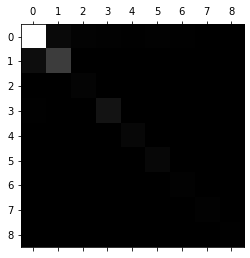

In [112]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [29]:
words = ['동아리','졸업조건','증명서','장학금','달구지','휴학신청','카페','힐링존','열람실','와이파이']
metrix['Q'] = 0

for i in range(len(metrix['comment'])):
    for z in range(len(words)):
        if metrix['comment'][i].find(words[z]) >= 0:
            metrix['Q'][i] = a[z]
        

C:\Users\82109\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\82109\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [32]:
qa = metrix[metrix['Q'] != 0].reset_index()
qaa = qa[{'comment','Q'}]

In [34]:
qaa.to_csv('comment.csv')

In [28]:
a = ['동아리는 강남대홈페이지에 대학생활 메뉴에 나와있어요',
     '졸업조건은 강남대홈페이지에 학사안내 메뉴중 학사에 있어요',
     '증명서 발급은 강남대홈페이지에 학사안내 메뉴중 학사에 있어요',
    '장학금 안내는 강남대홈페이지 강남광장 메뉴중 큐엔에이 메뉴에 있어요',
     '달구지는 08:10 ~ 19:15 까지 운행해요',
     '휴학신청은 강남대홈페이지에 학사안내 메뉴중 학사에 있어요',
     '강남대 카페는 천은관, 샬롬관 지하에 있어요',
     '강남대 힐링존은 천은관, 경천관, 샬롬관, 인사관에 있어요',
     '학기중 강남대 제1 제2 열람실은 06~23시 제3 열람실은 24시간 입니다',
     '강남대 와이파이 비밀번호는 officenet1 입니다.']
     